In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({'font.size': 14})
import dedalus.public as d3

import logging
logger = logging.getLogger(__name__)

## Example of nongeostrophic linear stability calculation for idealized bottom frontal zones

In [19]:
from frontal_zone import *
M = 4.e-5 # strength of bottom frontal zone (sqrt of horizontal buoyancy gradient)
k = 0. # cross-slope wavenumber (l=0 isolates fastest growing baroclinic mode)

# Know from sensitivity experiment that this is roughly the fastest growing mode
l = 1.e-4 * 2*np.pi # along-slope wavenumber (rad/m)

# Setup and solve eigenvalue problem for bottom frontal zone linear instability
ds = bottom_frontal_zone_instability(k, l, M)

2022-06-21 20:40:35,610 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 3s, Remaining: 0s, Rate: 3.8e-01/s


### Plot basic state

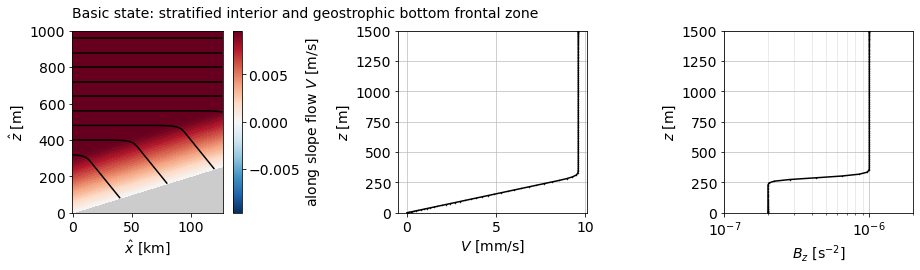

In [25]:
plt.figure(figsize=(13,4))
plt.subplot(1,3,1, facecolor=(0.8, 0.8, 0.8))

z_da = ds['problem'].namespace['zbasis'].global_grid(scale = 3/2)
Bz = ds['Bz'].evaluate()
Uz = ds['Uz'].evaluate()
Vz = ds['Vz'].evaluate()  
Bz.change_scales(1)
Uz.change_scales(1)
Vz.change_scales(1)
Bz = Bz['g']
Uz = Uz['g']
Vz = Vz['g']

ds['B'].change_scales(1)
ds['U'].change_scales(1)
ds['V'].change_scales(1)
z = ds['z']
U = ds['U']['g']
V = ds['V']['g']
B = ds['B']['g']

# project 1D solution to 2D for plotting
x = np.arange(0., 128.e3, 128.e1)[:, np.newaxis]
zr = z*np.cos(θ) + x*np.sin(θ)
xr = x*np.cos(θ) + z*np.sin(θ)

VV = np.tile(V.real, (x.size, 1))
BB = np.tile(B.real, (x.size, 1)) + N**2*np.cos(θ) * zr

VVmax = np.max(np.abs(VV))
plt.pcolor(xr*1e-3, zr, VV, cmap=plt.cm.get_cmap("RdBu_r"), vmin=-VVmax, vmax=VVmax)
plt.colorbar(label="along slope flow $V$ [m/s]")
plt.contour(xr*1e-3, zr, BB, levels=20, colors="k")
plt.ylim(0, 1000)
plt.xlabel(r"$\hat{x}$ [km]")
plt.ylabel(r"$\hat{z}$ [m]")
plt.title("Basic state: stratified interior and geostrophic bottom frontal zone", loc="left", fontsize=14, y=1.04)

plt.subplot(1,3,2)
plt.plot(V.real*1e3, z, "k.-", markersize=1., label="Dedalus LBVP")
plt.ylim(0, H)
plt.ylabel(r"$z$ [m]")
plt.xlabel(r"$V$ [mm/s]")
plt.grid(True, alpha=0.75)

plt.subplot(1,3,3)
plt.plot(np.diff(B.real)/np.diff(z) + N**2*np.cos(θ), 0.5*(z[1:]+z[:-1]), "k.-", markersize=1., label="Dedalus LBVP")
plt.ylim(0, H)
plt.xscale("log")
plt.ylabel(r"$z$ [m]")
plt.xlabel(r"$B_{z}$ [s$^{-2}$]")
plt.grid(True, alpha=0.75)
plt.xlim(1e-7, 2e-6)
plt.grid(True, which="minor", alpha=0.3)

plt.tight_layout()

## Solve the 3D Eigen-Value Problem (EVP) for small perturbations relative to the steady 1D SBML basic state

We begin by illustrating the method of finding the maximum eigenvalue (growth rate) for a single pair normal modes (chosen to be close to the fastest-growing baroclinic mode).

We linearize the sloping Boussinesq equations relative to the 1D basic state shown above. We consider arbitrary solutions
\begin{equation}
\phi(x,y,z,t) = \frac{1}{2}\left( \tilde{\phi}(z) \exp\{i(kx + \ell y - \omega t)\} + \tilde{\phi}^{*}(z) \exp\{-i(kx + \ell y - \omega t)\}  \right)
\end{equation}
with normal mode structures in $x$ and $y$ and yet to-be-determined complex frequencies $\omega = \Re\{ \omega \} + i\Im\{ \omega \}$ and slope-normal structure $\tilde{\phi}(z)$.

If $\Im \{ \omega \}>0$, then $\partial_{t} |\phi| \propto \Im\{\omega \} > 0$ and the perturbation amplitude will grow exponentially; conversely, any $\Im \{ \omega \}<0$ modes decay exponentially over time. (The $\Re\{ \omega \} \neq 0$ components represent oscillatory motions propagating with a phase speed $c_{p} = \Re\{ \omega \}/\ell$).

We are interested in the eigenvalues/vectors with the *largest positive imaginary component*, since these will be the relevant growth rate and modal structures. The figure below shows that only one vertical mode represents a growing instability—the other normal modes are physically meaningless and decay due to diffusion and/or friction.

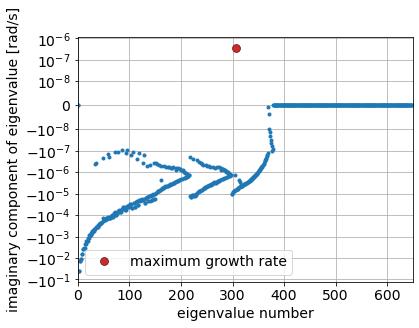

In [7]:
plt.figure(figsize=(6, 4.5))
plt.plot(ds['omega'].imag, ".")
plt.yscale("symlog", linthresh=1e-8)

plt.grid(True)
plt.grid(True, which="minor", alpha=0.2)
plt.xlabel("eigenvalue number")
plt.ylabel("imaginary component of eigenvalue [rad/s]")
plt.xlim(0, nz*5+9)
idx = ds['idx']
plt.plot(range(ds['omega'].size)[idx], ds['omega'].imag[idx],
        "C3o", markersize=8, label="maximum growth rate",
        markeredgecolor="k", markeredgewidth=0.5
)
plt.legend();

In [8]:
import numpy as np
nt = 128
ph = np.linspace(-np.pi, np.pi, nt, endpoint=False)

In [9]:
b_mode = np.zeros((nz, nt), dtype='complex128')
u_mode = np.zeros((nz, nt), dtype='complex128')
w_mode = np.zeros((nz, nt), dtype='complex128')
v_mode = np.zeros((nz, nt), dtype='complex128')

In [10]:
b = ds['b']['g']
u = ds['u']['g']
v = ds['v']['g']
w = ds['w']['g']

for t in range(nt):
    b_mode[:, t] = b*np.e**(1j*ph[t])
    u_mode[:, t] = u*np.e**(1j*ph[t])
    v_mode[:, t] = v*np.e**(1j*ph[t])
    w_mode[:, t] = w*np.e**(1j*ph[t])
    

ωr = ds['omega'][idx].real
ωi = ds['omega'][idx].imag

steerlevel = z[np.argmin(np.abs(V - ωr/l))]
def plot_steering_level():
    plt.axhline(steerlevel, color="k", linestyle="--")
    plt.annotate(r"steering level, $v(z) = c_{p} = \Re\{ω\}/\ell$", (-np.pi*0.95/l*1e-3, steerlevel*1.1), fontsize=12);

In [11]:
# Derived variables needed for EKE budget

Vx = Vz*np.sin(θ)
Ux = Uz*np.sin(θ)
κ = ds['κ']['g']

uz = d3.Differentiate(ds['u'], ds['problem'].namespace['zcoord']).evaluate()
uz.change_scales(1)
uz = uz['g']

vz = d3.Differentiate(ds['v'], ds['problem'].namespace['zcoord']).evaluate()
vz.change_scales(1)
vz = vz['g']

In [12]:
# EKE budget terms

VBP = ( 0.5*( w.conj()*b*np.cos(θ) + u.conj()*b*np.sin(θ) ) ).real

VSP = (-0.5*((v.conj()*w*np.cos(θ) + u.conj()*v*np.sin(θ)) * Vz*np.cos(θ)
            +(u.conj()*w*np.cos(θ) + u.conj()*u*np.sin(θ)) * Uz*np.cos(θ))).real

LSP = (-0.5*((u.conj()*v*np.cos(θ) - v.conj()*w*np.sin(θ)) * Vz*np.sin(θ)
            +(u.conj()*u*np.cos(θ) - u.conj()*w*np.sin(θ)) * Uz*np.sin(θ))).real # Is this correct?

DKE =-( 0.5*( κ * (uz.conj()*uz + vz.conj()*vz ))).real

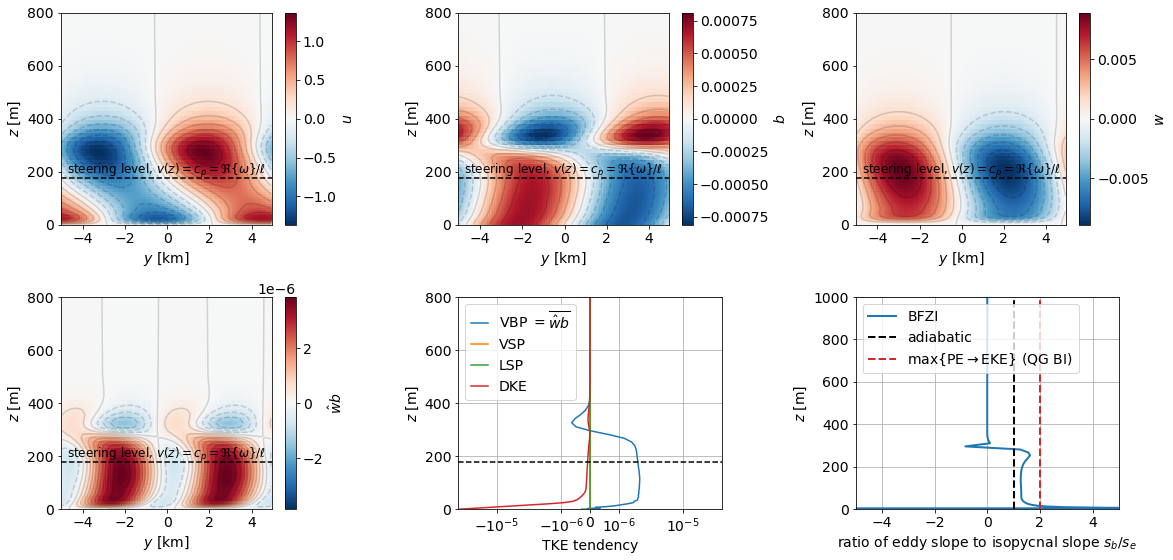

In [14]:
plt.figure(figsize=(16.5, 8))

plt.subplot(2,3,1)
plt.pcolor(ph/l*1e-3, z, u_mode.real, cmap=plt.get_cmap("RdBu_r"))
plt.colorbar(label=r"$u$")
plt.contour(ph/l*1e-3, z, u_mode.real, colors="k", alpha=0.15, levels=15)
plt.ylim(0, 800)
plt.xlabel(r"$y$ [km]")
plt.ylabel(r"$z$ [m]")
plot_steering_level()

plt.subplot(2,3,2)
plt.pcolor(ph/l*1e-3, z, b_mode.real, cmap=plt.get_cmap("RdBu_r"))
plt.colorbar(label=r"$b$")
plt.contour(ph/l*1e-3, z, b_mode.real, colors="k", alpha=0.15, levels=15)
plt.ylim(0, 800)
plt.xlabel(r"$y$ [km]")
plt.ylabel(r"$z$ [m]")
plot_steering_level()

plt.subplot(2,3,3)
plt.pcolor(ph/l*1e-3, z, w_mode.real, cmap=plt.get_cmap("RdBu_r"))
plt.colorbar(label=r"$w$")
plt.contour(ph/l*1e-3, z, w_mode.real, colors="k", alpha=0.15, levels=15)
plt.ylim(0, 800)
plt.xlabel(r"$y$ [km]")
plt.ylabel(r"$z$ [m]")
plot_steering_level()

plt.subplot(2,3,4)
wvb_mode = (w_mode.real*np.cos(θ) + u_mode.real*np.sin(θ))*b_mode.real
uhb_mode = (u_mode.real*np.cos(θ) - w_mode.real*np.sin(θ))*b_mode.real
vabsmax = np.max(np.abs(wvb_mode))
plt.pcolor(ph/l*1e-3, z, wvb_mode, cmap=plt.get_cmap("RdBu_r"), vmin=-vabsmax, vmax=vabsmax)
plt.colorbar(label=r"$\hat{w}b$")
plt.contour(ph/l*1e-3, z, wvb_mode, colors="k", alpha=0.15, levels=15)
plt.ylim(0, 800)
plt.xlabel(r"$y$ [km]")
plt.ylabel(r"$z$ [m]")
plot_steering_level()

plt.subplot(2,3,5)
plt.plot(VBP, z, label=r"VBP $= \overline{\hat{w}b}$")
plt.plot(VSP, z, label="VSP")
plt.plot(LSP, z, label="LSP")
plt.plot(DKE, z, label="DKE")
plt.ylim(0, 800)
plt.ylabel(r"$z$ [m]")
plt.xlabel(r"TKE tendency")
plt.xlim(-4e-5, 4e-5)
plt.grid(True)
plt.xscale("symlog", linthresh=1e-6, linscale=0.4)
plot_steering_level()
plt.legend(loc="upper left", handlelength=1.2)

plt.subplot(2,3,6)
sb = Bz.real*np.sin(θ) / (N**2 + Bz.real*np.cos(θ))
se = np.mean(wvb_mode, axis=1)/np.mean(uhb_mode, axis=1)
plt.plot(sb/se, z, lw=2, label="BFZI")
plt.xlim(-5, 5)
plt.ylim(0, 1000)
plt.axvline(1, linestyle="--", color="k", lw=2., label="adiabatic")
plt.axvline(2, linestyle="--", color="C3", lw=2., label=r"max$\{$PE$\rightarrow$EKE$\}$ (QG BI)")
plt.grid(True)
plt.legend(loc="upper left")
plt.ylabel(r"$z$ [m]")
plt.xlabel(r"ratio of eddy slope to isopycnal slope $s_{b}/s_{e}$")

plt.tight_layout()

In [15]:
print(f"EKE tendency (buoyancy production - dissipation): {np.sum(VBP[:-1]*np.diff(z)) - np.sum(DKE[:-1]*np.diff(z))}")

EKE tendency (buoyancy production - dissipation): 0.0008111663905820976


**A note on computing higher moments with complex conjugates...**

In [16]:
np.isclose(
    np.mean(w_mode.real*b_mode.real, axis=1),      # where w ~ ϕ cos(ly - ωt)
    0.5 * (ds['b']['g']*ds['w']['g'].conj()).real,  # where w ~ [ϕ e^i(ly - ωt) + ϕ* e^-i(ly - ωt)], need to divide by 2!
    atol=0., rtol=1e-12
).all()

True